<a href="https://colab.research.google.com/github/Rabidgeek/Sprint15/blob/main/JMR_DS_433_Autoencoders_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An **autoencoder** is a type of artificial neural network used to learn efficient data representations in an unsupervised manner. The aim of an autoencoder is to learn a representation (coding) for a set of data, by training the network to capture the signal and ignore the noise, so as to reconstruct the data as well as possible. Autoencoders consist of two parts: the **encoder** which transforms the data to a **coding** (often -- but not always -- of lower dimension), and the **decoder**, which reconstructs the original data from its **coding**. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the components of an autoencoder
* <a href="#p2">Part 2</a>: Apply an autoencoder to an image reconstruction problem
* <a href="#p3">Part 3</a>: Apply an autoencoder to a basic information retrieval problem, i.e. a "recommender system"

__Problem:__ Can we embed images in vectors of a specified size, as spacy does for words and documents?

__Solution:__ Use an autoencoder

Why would we want to represent an image as a fixed-sized vector? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already encountered *representation learning* when we modeled text documents via 300-dimensional word embeddings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspects of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Autoencoders a special case of feed-forward networks (the kind we've been studying); the weights and biases are determined by backpropagation and gradient descent. 

# 1. Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process is, as usual, minimizing a loss function: 
$ L(x, g(f(x))) $

- $x$ is the input
- $f$ is the encoder function, $f(x)$ is the coding
- $g$ is the decoder function, g(f(x))) is the reconstructed input
- $L$ is a loss function that  penalizes the reconstructed input for being dissimiliar from $x$ (such as mean squared error)


![](https://miro.medium.com/max/3110/0*uq2_ZipB9TqI9G_k)

## Follow Along
We'll use an autoencoder to compress and reconstruct images from the `quickdraw10` data set.
### Simple Autoencoder

#### Imports

In [1]:
# imports 
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%load_ext tensorboard
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.metrics import mean_squared_error




#### Get the the `quickdraw` data set

In [2]:
# get the quickdraw data set
URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

# create directory to store images that we'll we will be using to train auto-encoders 
path_to_downloaded_npz_file = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)
data = np.load(path_to_downloaded_npz_file)

x_train = data['arr_0']
y_train = data['arr_1']

print(x_train.shape)
print(y_train.shape)

25421363/25421363 [==============================] - 0s 0us/step
(100000, 784)
(100000,)


In [3]:
# 28x28 images are already flattened into 784-dimensional row vectors 
x_train[0].shape

(784,)

`quickdraw10` class names

In [4]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

Plot some `quickdraw10` images, with their labels

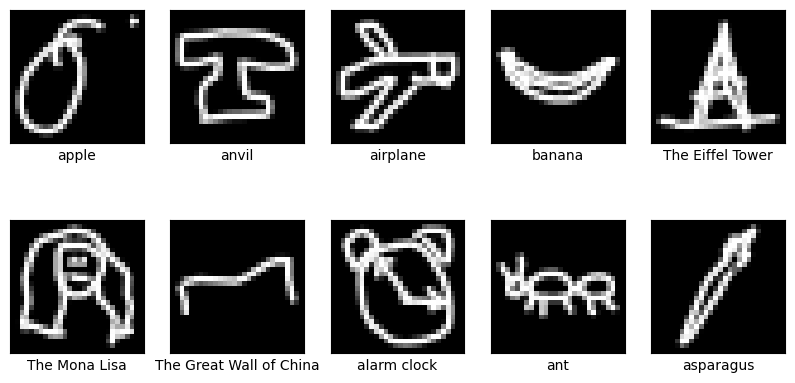

In [5]:
plt.figure(figsize=(10,5))
start = 0

# helper function used to plot images 
for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.gray)
    plt.xlabel(name)
    start += 10000
plt.show()

### Prepare the data for modeling

In [6]:

# It's often a good idea to shuffle the training data before using it to build a model
x_train, y_train = shuffle(x_train, y_train)

# Normalize 
# scale the pixel values between 0 and 1 by dividing by the largest pixel value (i.e. 255)
max_pixel_value = x_train.max()
print(f'maximum pixel value = {max_pixel_value}')
x_train = x_train.astype('float32') / max_pixel_value
print(x_train.shape)

maximum pixel value = 255
(100000, 784)


In [7]:
# Check that our pixel values are indeed normalized 
assert x_train.min() == 0.0
assert x_train.max() == 1.0

### Build the simple autoencoder
Notice that for the output layer below, we are "borrowing" the same structure and<br> 
the same loss function (cross-entropy) as the output of a binary class problem! <br>

A neuron with a sigmoid activation function outputs a single number -- the probability of being in the positive class. <br>

But normalized pixel values, like probabilities, are also on the interval $[0, 1]$. <br>
We can interpret the probability outputs as pixel values: the "brightness", or "lit-up-ness" of a pixel. <br>

Long story short, we can use $784$ neurons, each with a sigmoid activation function to produce our output pixel values.

In [8]:
### build simple auto-encoder

# save input data dims to variable 
input_dims = x_train.shape[1]
shape = (input_dims,)

# decoder output size (i.e. 784 dims)
decoding_size = input_dims

# encoder output size
coding_size = 64

# Create input layer 
inputs = Input(shape=shape)

# Create encoder layer 
encoded = Dense(coding_size, activation="relu")(inputs)

# Create decoder layer 
decoded = Dense(decoding_size,activation="sigmoid")(encoded)
#decoded = Dense(decoding_size)(encoded)#,activation="sigmoid")

# bring it all together using the Functional API
autoencoder_simple = Model(inputs=inputs, outputs=decoded, name="simple_autoencoder")

### Compile the simple autoencoder

In [9]:
autoencoder_simple.compile(optimizer='nadam', loss='binary_crossentropy', metrics = [mean_squared_error])
#autoencoder_simple.compile(optimizer='nadam', loss='mse', metrics = [mean_squared_error])

In [10]:
autoencoder_simple.summary()

Model: "simple_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


### Activity: 
Explain the number of parameters in the encoder and decoder layers.<br>
Your explanation here.

### Fit (train) the simple autoencoder

In [11]:
%%time
# takes about 30 sec with min_delta=0.001, patience=2

# cut off training if loss doesn't decrease by a certain amount over X number of epoches 
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)

#  tensorboard callback
logdir = os.path.join("logs", f"SimpleAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

# fit the autoencoder model (train)
autoencoder_simple.fit(x_train, # input image to encoder
                        x_train, # provide input image as the target, so that the model learns how to reconstruct the input image 
                        epochs=100,
                        batch_size=64,
                        shuffle=True,
                        validation_split=0.2,
                        verbose = True,
                        callbacks=[stop, tensorboard], 
                        workers=10)

Epoch 1/100
1250/1250 [==============================] - 11s 4ms/step - loss: 0.2610 - mean_squared_error: 0.0519 - val_loss: 0.2021 - val_mean_squared_error: 0.0325
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1901 - mean_squared_error: 0.0286 - val_loss: 0.1847 - val_mean_squared_error: 0.0269
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1821 - mean_squared_error: 0.0260 - val_loss: 0.1816 - val_mean_squared_error: 0.0259
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1800 - mean_squared_error: 0.0253 - val_loss: 0.1803 - val_mean_squared_error: 0.0253
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1790 - mean_squared_error: 0.0249 - val_loss: 0.1796 - val_mean_squared_error: 0.0251
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1784 - mean_squared_error: 0.0247 - val_loss: 0.1794 - val_mean_squared_error: 0.0250
CPU times

### Use the trained model to reconstruct the input images


In [12]:
%%time
# encode and decode all the images
#     original images go in (i.e, x_train)
#     decoded images come out (i.e. a non-perfect reconstruction of x_train)
decoded_imgs = autoencoder_simple.predict(x_train)

3125/3125 [==============================] - 5s 2ms/step
CPU times: user 7.95 s, sys: 1.02 s, total: 8.97 s
Wall time: 16 s


In [13]:
print(decoded_imgs.shape)
print(type(decoded_imgs))

(100000, 784)
<class 'numpy.ndarray'>


### Visually compare reconstructed and original images

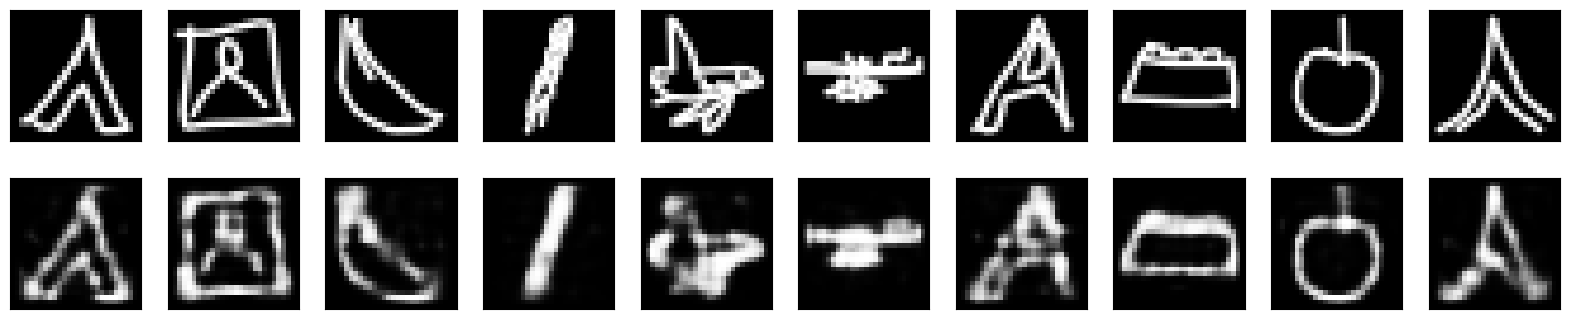

In [14]:
def plot_images(x_train, decoded_imgs):
  n_display = 10  # how many digits we will display
  plt.figure(figsize=(20, 4))
  for index in range(n_display):
      # display original
      ax = plt.subplot(2, n_display, index + 1)
      plt.imshow(x_train[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n_display, index + 1 + n_display)
      plt.imshow(decoded_imgs[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


plot_images(x_train, decoded_imgs)

## Challenge

You'll be expected to discuss the components of a simple autoencoder and their purpose. 

# 2. Train an Autoencoder (Learn)
<a id="p2"></a>
In this section we will learn how to build and train deep autoencoders and convolutional autoencoders

## Overview

As long as our architecture maintains a symmetric "hourglass" shape, we can continue to add layers and create a deeper network. 

## Follow Along

## 2.1 Deep Autoencoder

In [15]:
#                                encoder     ->    decoder 
# dim of each hidden layer: 784, 128, 64, 32 -> 64, 128, 784

# input layer 
inputs = Input(shape=(784,))

#======================================================
# Encoder: produces encoded representation of the input
# Like "zip"
#======================================================
# 1st encoding layer (compresses input image into 128 dim vect)
encoded_1 = Dense(256, activation="relu")(inputs)

# 2nd encoding layer (compresses 128 dim vect into 64 dim vect)
encoded_2 = Dense(128, activation="relu")(encoded_1)

# 3rd encoding layer (compresses 64 dim vect into 32 dim vect)
# the output of this layer is the "codings" 
encoded_3 = Dense(64, activation="relu")(encoded_2)

#===========================================================
# Decoder: produces the reconstructed input from the codings
# Like "unzip"
#===========================================================

# 1st decoding layer (decompresses 32 dim vect into 64 dim vect)
decoding_1 = Dense(128, activation="relu")(encoded_3)

# 2nd decoding layer (decompresses 64 dim vect into 128 dim vect)
decoding_2 = Dense(256, activation="relu")(decoding_1)

# 3rd decoding layer (decompresses 128 dim vect into 784 dim vect)
decoding_3 = Dense(784, activation="sigmoid")(decoding_2)

# build an autoencoder model, using the Model API
autoencoder_deep = Model(inputs=inputs, outputs=decoding_3, name="autoencoder_deep")


In [16]:
autoencoder_deep.summary()

Model: "autoencoder_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 784)          

In [ ]:
%%time
# compile & fit model
# takes about 2 min with min_delta=0.001, patience=2

autoencoder_deep.compile(optimizer='nadam', loss='binary_crossentropy', metrics = [mean_squared_error])

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)

logdir = os.path.join("logs", f"DeepAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder_deep.fit(x_train, 
                     x_train,
                     epochs=100,
                     batch_size=64,
                     shuffle=True,
                     validation_split=0.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/100
1250/1250 [==============================] - 11s 6ms/step - loss: 0.2521 - mean_squared_error: 0.0510 - val_loss: 0.2169 - val_mean_squared_error: 0.0395
Epoch 2/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.2040 - mean_squared_error: 0.0347 - val_loss: 0.1953 - val_mean_squared_error: 0.0317
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1897 - mean_squared_error: 0.0298 - val_loss: 0.1859 - val_mean_squared_error: 0.0284
Epoch 4/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.1818 - mean_squared_error: 0.0270 - val_loss: 0.1785 - val_mean_squared_error: 0.0258
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1765 - mean_squared_error: 0.0252 - val_loss: 0.1762 - val_mean_squared_error: 0.0251
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1728 - mean_squared_error: 0.0240 - val_loss: 0.1722 - val_mean_squared_error: 0.0238
Epoch 7/1

### Use the trained model to reconstruct the input images

In [ ]:
decoded_imgs = autoencoder_deep.predict(x_train)
print(type(decoded_imgs))

### Compare reconstructed to original images

In [ ]:
plot_images(x_train, decoded_imgs)

##2.2 Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist of a stack of `Conv2D` and `MaxPooling2D` layers, while the decoder will consist of a stack of `Conv2D` and `UpSampling2D` layers. Here `MaxPooling2D` layers and `Upsampling2D` layers are used for spatial down-sampling and up-sampling, respectively.

### Example Image of a Convolutional Autoencoder 

![](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)

In [ ]:
# we need to transform our row vectors back into matrices
# because the convolutional and pooling layers expect images in the form of matrices 
x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_train[0].shape

In [21]:

# define some parameters and the dims of each, individual sample 
input_shape = (28,28,1)

# weight matrix parameters
# size of the convolution kernel (or filter)
conv_filter_size = (3,3)
pooling_filter_size = (2,2)

# input layer 
inputs = Input(shape=input_shape)

### encoding layers ### 
# This layer takes 28x28 image as input and produces 16 feature maps of size 14x14
encoded = Conv2D(16, conv_filter_size, activation="relu", padding="same")(inputs)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# This layer takes the previous layer as input and produces 8 feature maps of size 7x7
encoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# This layer takes the previous layer as input and produces 8 feature maps of size 4x4
encoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# flatten 3D tensor into 1D vector in preparation for the Dense layer 
encoded = Flatten()(encoded)

# this is the coding, the output of the encoder layer
coding = Dense(64, activation="relu")(encoded)

# reshape 1D vectors into 2D arrays, for input to Convolution layers 
#     64 = 4 * 4 * 4
encoded = Reshape((4,4,4))(coding)

### decoding layers ###
decoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
decoded = UpSampling2D(pooling_filter_size)(decoded)
                  
decoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(decoded)
decoded = UpSampling2D(pooling_filter_size)(decoded)
                  
decoded = Conv2D(16, conv_filter_size, activation="relu")(decoded) # in order to get to 14x14 instead of 167x16
decoded = UpSampling2D(pooling_filter_size)(decoded)

# because this is the final reconstruction of the original image,
#   we must necessarily use a single weight matrix for the convolution 
#   so that the final output is a 2D matrix and not a rank 3 Tensor (i.e. a volume)
decoded = Conv2D(1, conv_filter_size, activation="sigmoid", padding="same")(decoded)

# out it all together using the Model API
conv_autoencoder = Model(inputs=inputs, outputs=decoded, name="conv_autoencoder")

In [22]:
conv_autoencoder.summary()

Model: "conv_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)      

In [23]:
%%time
# takes about 5 min on Colab with min_delta=0.01, patience=5
# compile & fit model

conv_autoencoder.compile(optimizer='nadam', loss='binary_crossentropy', metrics = [mean_squared_error])

# make tensorboard callback
logdir = os.path.join("logs", f"ConvolutionalAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

# early stopping callback
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)


conv_autoencoder.fit(x_train, 
                     x_train,
                     epochs=50,
                     batch_size=32,
                     shuffle=True,
                     validation_split=0.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/50
2500/2500 [==============================] - 30s 8ms/step - loss: 0.2627 - mean_squared_error: 0.0562 - val_loss: 0.2344 - val_mean_squared_error: 0.0467
Epoch 2/50
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2274 - mean_squared_error: 0.0443 - val_loss: 0.2227 - val_mean_squared_error: 0.0425
Epoch 3/50
2500/2500 [==============================] - 18s 7ms/step - loss: 0.2191 - mean_squared_error: 0.0413 - val_loss: 0.2161 - val_mean_squared_error: 0.0402
Epoch 4/50
2500/2500 [==============================] - 20s 8ms/step - loss: 0.2144 - mean_squared_error: 0.0396 - val_loss: 0.2131 - val_mean_squared_error: 0.0392
Epoch 5/50
2500/2500 [==============================] - 20s 8ms/step - loss: 0.2110 - mean_squared_error: 0.0384 - val_loss: 0.2092 - val_mean_squared_error: 0.0377
Epoch 6/50
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2084 - mean_squared_error: 0.0375 - val_loss: 0.2070 - val_mean_squared_error: 0.0369
Epoch 7/50

In [24]:
decoded_imgs = conv_autoencoder.predict(x_train)
print(decoded_imgs.shape)
print(type(decoded_imgs))
# squeeze singleton dimension
decoded_imgs = np.squeeze(decoded_imgs)
print(decoded_imgs.shape)

3125/3125 [==============================] - 7s 2ms/step
(100000, 28, 28, 1)
<class 'numpy.ndarray'>
(100000, 28, 28)


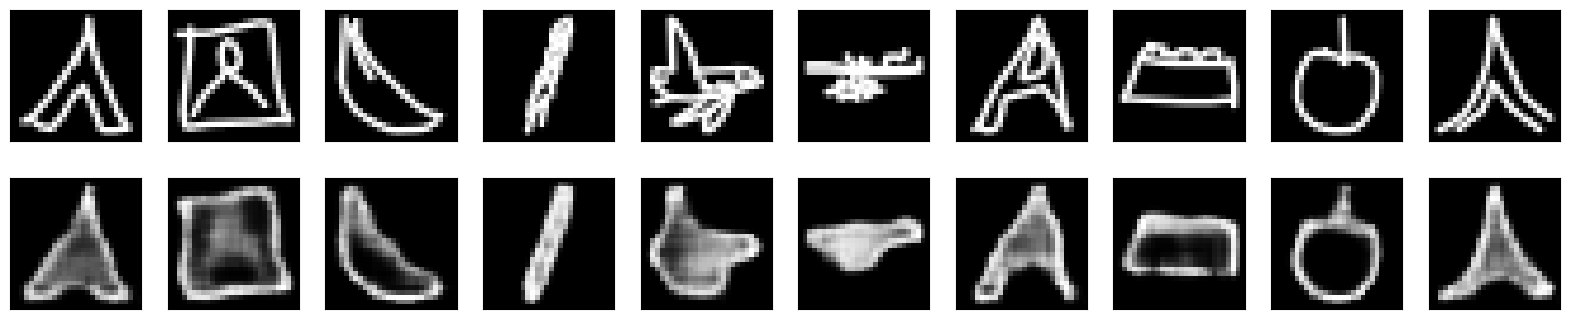

In [25]:
plot_images(x_train, decoded_imgs)

#### Visualization of the Representations (codings)

3125/3125 [==============================] - 6s 2ms/step


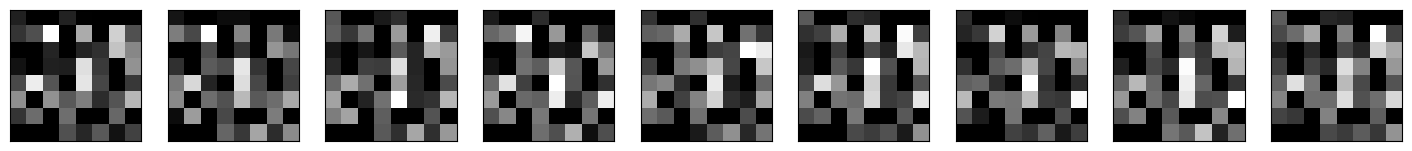

In [26]:
# we have isolated the encoder portion of our auto-encoder so that we can access the encoder vector (i.e. the output of the encoder)
encoder = Model(inputs=inputs, outputs=encoded)

# the predictions (i.e. the output) of our encoder model are the original images encoder into a smaller dim space (i.e. the encoder vectors)
encoded_imgs = encoder.predict(x_train)

# display the codings for the above input images
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


The above images are the $64$-dimensional encoded vectors (codings), <br>represented as $8\times8$ images, for some of the input images from `x_train`<br>
Notice that we really can't interpret the encoded vectors -- this is the price we pay for dimensionality reduction! <br>
The features in the encoded vectors are *non-linear* combinations of the input features. <br>
Recall that PCA (Principal Components Analysis)
-- a *linear* dimensionality reduction technique -- also incurs the cost of interpretability loss.<br>
Reference: [Principal Component Analysis Explained Visually](https://setosa.io/ev/principal-component-analysis/). 

## Challenge

You will be expected to build and train autoencoders at some point in the near future!

# 3. Application of Autoencoders: Information Retrieval -- Recommender Systems (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

We are going to perform the following: 

- Build an encoder model
- Train a NearestNeighbors on encoded images
- Choose a query image 
- Find similar encoded images using the trained NearestNeighbors model
- Check our results: make sure that the selected images are in fact similar to the query image!

### 3.1 Build an encoder model

Use the `Model` class and the encoder layers to build an encoded model. Remember that we first need to train a full autoencoder model, which has both an encoder and and a decoder, before we can "break off" the trained encoder portion. 

In [27]:
coding.shape

TensorShape([None, 64])

In [28]:
# in Section 2, we isolated the encoder portion of the convolutional auto-encoder 
# in the object named coding, so that we can access the encoder part of the model

# Build the encoder, which takes input images and producse flattened codings
encoder = Model(inputs=inputs, outputs=coding)

# Run the encoder on the input data set
encoded_imgs = encoder.predict(x_train)

3125/3125 [==============================] - 5s 2ms/step


In [29]:
# now we can pass in our row vectors into a Nearest Neighbors model
print(encoded_imgs.shape)

(100000, 64)


###3.2  Train a NearestNeighbors model

Build a `NearestNeighbors` model and train it on the encoded images. 


In [30]:
%%time

# fit KNN on encoded images (i.e. the encoded vectors)
nn = NearestNeighbors()

# pass in the encoded images (i.e. the encoded vectors )
nn.fit(encoded_imgs)

CPU times: user 6.01 ms, sys: 0 ns, total: 6.01 ms
Wall time: 4.84 ms


NearestNeighbors()

### Select a query image

Next, we chose an image that we will pass into the `NearestNeighbors` model in order to find similar images. <br>
Feel free to select a different image.

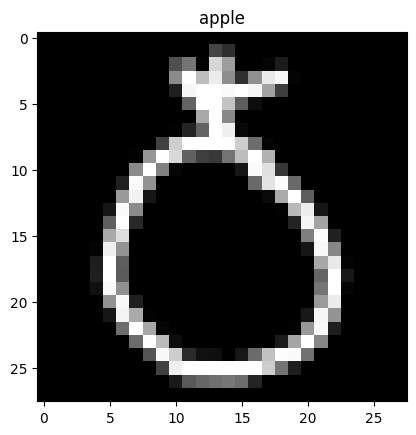

In [31]:
# get a query image 
query =  42
query_img = x_train[query]
query_label = class_names[y_train[query]]

# we will pass the query image into NearestNeighbors in order to find similar images, 
#      by identifying images whose encoded vectors are closest in distance to the query image's encoded vector
plt.title(query_label)
plt.imshow(query_img);

### 3.3 Find and Retrieve Images that are Similar to the Query Image
Use the encoder to encode our query image

In [32]:
# format the query image for input to our model
print(query_img.shape)

(28, 28)


In [33]:
# reshape for input to encoder: the extra dimension is for the batch index
query_img_reshaped = np.reshape(query_img,(1,28,28) )
print(query_img_reshaped.shape)

(1, 28, 28)


In [34]:
# encode the query image to a lower dimensional vector using our encoder model 
query_img_encoded = encoder.predict(query_img_reshaped)

1/1 [==============================] - 0s 143ms/step


In [35]:
query_img_encoded.shape

(1, 64)

Select the 10 nearest neighbor images to our query image

In [36]:
_, neigh_ind = nn.kneighbors(query_img_encoded,n_neighbors=11)

Nearest neighbor distances:

Nearest neighbor indexes: <br>
Of course the model identifies the query image as the closest nearest neighbor to itself. <br>
That's why we asked for 11 nearest neigbhbors when really we wanted 10!

In [37]:
neigh_ind

array([[   42, 68958, 19991, 41273, 25712, 28378, 29604, 40319, 45277,
        35949, 39643]])

### 4. How did our model perform?
Let's check!<br>
Not bad!<br>
With codings of 32 pixels -- a compression factor of about 25 -- <br>
our model performed well when asked for images of the same class as the query image!

CPU times: user 160 ms, sys: 3.84 ms, total: 164 ms
Wall time: 161 ms


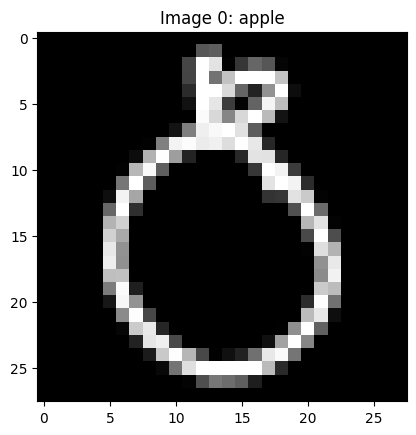

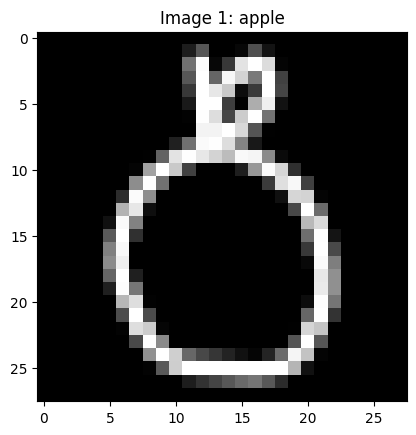

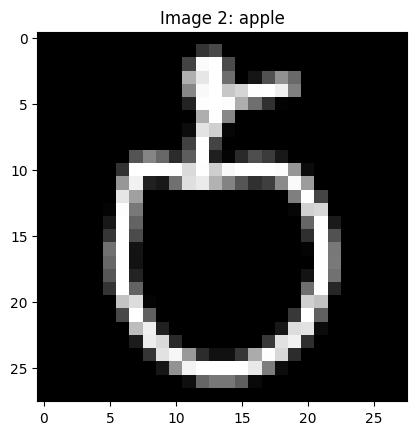

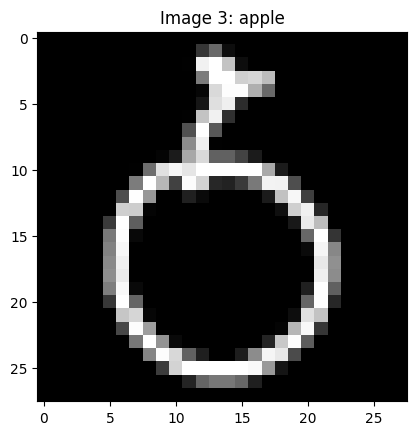

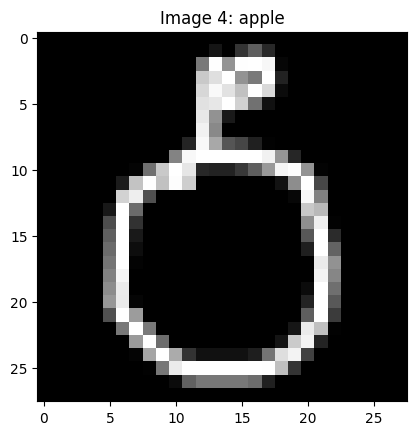

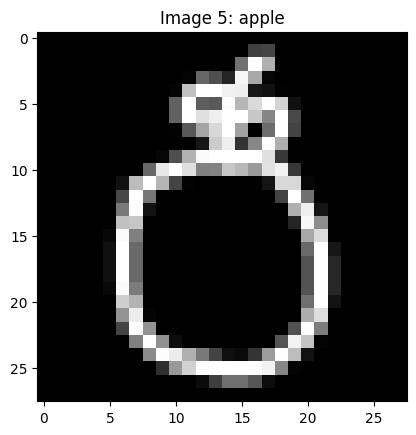

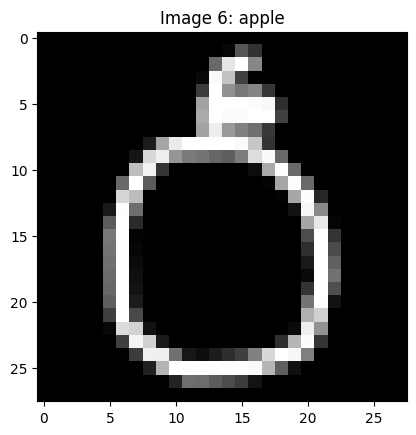

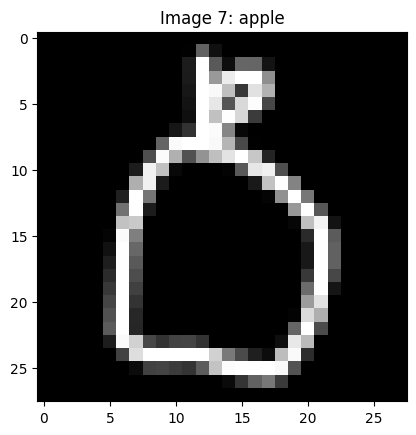

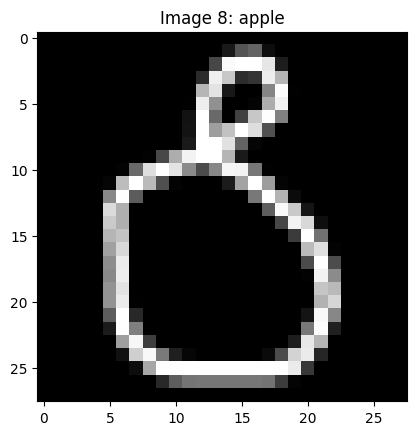

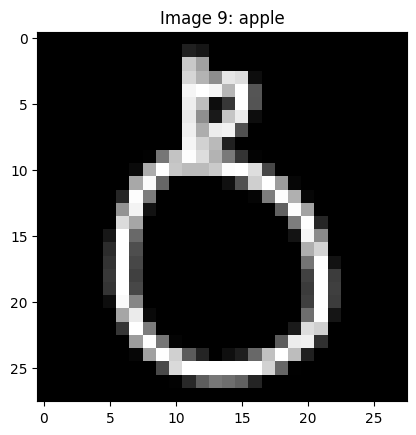

In [38]:
%%time
count = 0
for nearest_neigh_index in neigh_ind[0][1:]:
  plt.figure()
  plt.imshow(x_train[nearest_neigh_index])
  plt.title(f'Image {count}: {class_names[y_train[nearest_neigh_index]]}')
  count+=1

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know which part of the autoencoder (the encoder) to use to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the components of an autoencoder
    - Encoder
    - Decoder
    - Codings
* <a href="#p2">Part 2</a>: Train an autoencoder to do image compression and reconstruction
    - Can do this easily in Keras
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoencoder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AutoEncoders are used for dimensionality reduction, reverse image search, and many more applications. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__<br>
- [AI Summer -- autoencoder resources](https://theaisummer.com/search/?s=autoencoders)